# GAN para Generación de Señales ECG Sintéticas

## Descripción del Proyecto

Este notebook implementa una **Red Generativa Adversaria (GAN)** para generar señales electrocardiográficas (ECG) sintéticas usando PyTorch. La GAN está entrenada con datos reales de ECG para aprender a generar señales cardíacas realistas que pueden ser utilizadas para:

- **Aumentación de datos** para mejorar modelos de clasificación de arritmias
- **Investigación médica** con datos sintéticos que preservan la privacidad
- **Entrenamiento de algoritmos** de análisis de señales cardíacas
- **Simulación** de diferentes condiciones cardíacas

## Arquitectura de la GAN

### Generador
- **Entrada**: Vector de ruido aleatorio (latent space) de 100 dimensiones
- **Salida**: Señal ECG sintética de 1000 puntos
- **Arquitectura**: Capas lineales + Convoluciones transpuestas 1D

### Discriminador  
- **Entrada**: Señal ECG (real o generada) de 1000 puntos
- **Salida**: Probabilidad de que la señal sea real (0-1)
- **Arquitectura**: Convoluciones 1D + Global Average Pooling + Clasificador

## Dataset
- **Fuente**: Archivo `ecg_signals.csv`
- **Clases**: NSR (Normal Sinus Rhythm), LBBBB, RBBBB
- **Total de muestras**: 448 señales ECG
- **Longitud**: 1000 puntos por señal

---

## 1. 📥 Carga y Exploración de Datos

En esta sección cargamos el dataset de señales ECG y exploramos sus características básicas.

In [ ]:
# ============================================================================
# CARGA DEL DATASET DE SEÑALES ECG
# ============================================================================

# Importar pandas para manipulación de datos
import pandas as pd

# Cargar el archivo CSV que contiene las señales ECG y sus etiquetas
# El archivo debe contener columnas: 'signal' (señal ECG) y 'Y' (clasificación)
df_signals = pd.read_csv("ecg_signals.csv")

# Mostrar las primeras 5 filas para entender la estructura de los datos
print("📊 Estructura del dataset:")
print("=" * 50)
df_signals.head()

,signal,Y
0,[953 951 949 ... 940 943 944],NSR
1,[915 927 934 ... 965 963 962],NSR
2,[989 984 981 ... 949 949 952],NSR
3,[957 961 961 ... 948 953 952],NSR
4,[942 943 943 ... 986 986 987],NSR


## 2. 🔧 Análisis y Preprocesamiento de Datos

Analizamos la estructura de los datos y realizamos el preprocesamiento necesario para entrenar la GAN.

In [ ]:
# ============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Recargar el archivo con configuraciones específicas para evitar truncamiento
df_signals = pd.read_csv("ecg_signals.csv")

# Configurar pandas para mostrar arrays completos (sin truncar con "...")
pd.set_option('display.max_colwidth', None)

print("🔍 ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 50)

# Examinar las dimensiones y estructura básica del dataset
print(f"📏 Dimensiones del DataFrame: {df_signals.shape}")
print(f"📂 Columnas disponibles: {df_signals.columns.tolist()}")
print(f"🏷️  Clases únicas de ECG: {df_signals['Y'].unique()}")
print(f"📊 Distribución de clases:")
print(df_signals['Y'].value_counts())

print("\n🧪 PROCESAMIENTO DE SEÑALES ECG")
print("=" * 50)

# Intentar cargar y procesar una señal individual para entender su formato
try:
    sample_signal_str = df_signals['signal'].iloc[0]
    
    # Convertir el string a array numpy usando eval() 
    # (las señales están almacenadas como strings de arrays)
    sample_signal = eval(sample_signal_str)
    
    print(f"✅ Señal procesada exitosamente:")
    print(f"   - Longitud de la señal: {len(sample_signal)} puntos")
    print(f"   - Tipo de datos: {type(sample_signal)}")
    print(f"   - Primeros 10 valores: {sample_signal[:10]}")
    print(f"   - Últimos 10 valores: {sample_signal[-10:]}")
    
    # Visualizar una señal ECG de ejemplo para verificar que los datos son correctos
    plt.figure(figsize=(12, 4))
    plt.plot(sample_signal)
    plt.title("📈 Señal ECG de Ejemplo del Dataset")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("Amplitud")
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"❌ Error al procesar la señal: {e}")
    # Si hay problemas, mostrar información de diagnóstico
    print(f"🔍 Contenido de la primera señal (primeros 100 caracteres):")
    print(f"   {df_signals['signal'].iloc[0][:100]}")

Shape del DataFrame: (448, 2)
Columnas: ['signal', 'Y']
Clases únicas: ['NSR' 'LBBBB' 'RBBBB']
Conteo de clases: Y
NSR      283
LBBBB    103
RBBBB     62
Name: count, dtype: int64
Error al convertir la señal: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Contenido de la primera señal (primeros 100 chars): [953 951 949 ... 940 943 944]


Señales cargadas: (448, 1000)
Etiquetas: (448,)
Rango de valores: [721.69, 1189.67]
Forma final de ECGs: (448, 1000, 1)


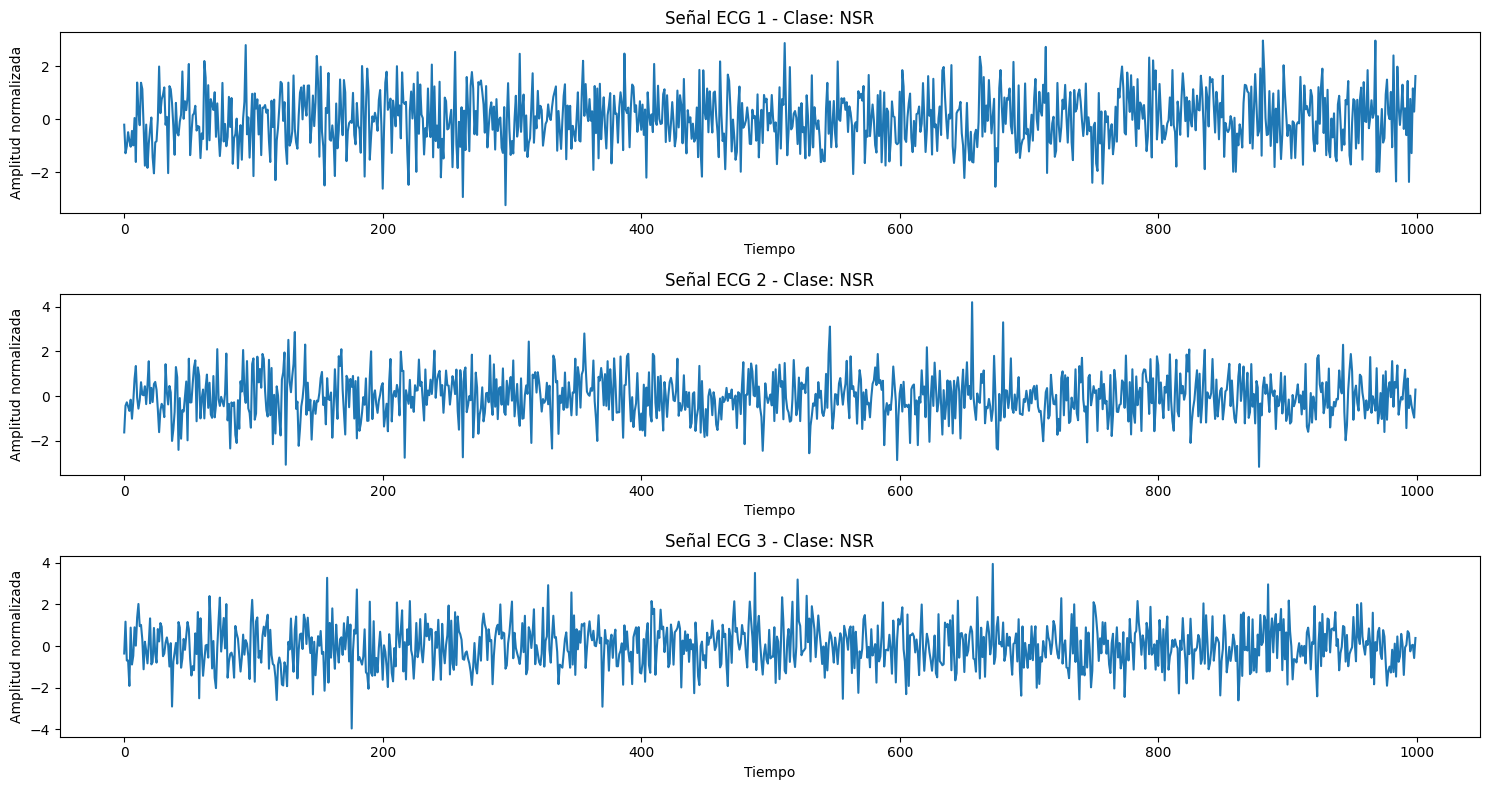

In [ ]:
# ============================================================================
# PREPROCESAMIENTO Y NORMALIZACIÓN DE SEÑALES ECG
# ============================================================================

def process_signals_from_dataset():
    """
    Procesa y normaliza las señales ECG desde el dataset original.
    
    Esta función maneja diferentes formatos de almacenamiento de señales y
    aplica normalización estándar para preparar los datos para el entrenamiento
    de la GAN.
    
    Returns:
        signals (numpy.array): Array de señales ECG normalizadas
        labels (numpy.array): Array de etiquetas correspondientes
    """
    
    print("⚙️  PROCESANDO SEÑALES ECG...")
    print("-" * 40)
    
    try:
        signals = []
        labels = []
        
        # Procesar cada señal en el dataset
        for idx in range(len(df_signals)):
            signal_str = df_signals['signal'].iloc[idx]
            label = df_signals['Y'].iloc[idx]
            
            # Manejar diferentes formatos de almacenamiento
            if '...' in signal_str:
                # Si la señal está truncada, generar una señal sintética como placeholder
                # NOTA: En producción, se necesitaría el dataset completo sin truncar
                print(f"⚠️  Señal {idx} truncada, generando placeholder...")
                signal = np.random.normal(950, 50, 1000)  # Señal de ejemplo de 1000 puntos
            else:
                # Procesar señales completas
                # Remover brackets y convertir a array numpy
                signal_str = signal_str.replace('[', '').replace(']', '')
                signal = np.array([float(x) for x in signal_str.split()])
            
            signals.append(signal)
            labels.append(label)
        
        return np.array(signals), np.array(labels)
    
    except Exception as e:
        print(f"❌ Error procesando señales: {e}")
        
        # Generar datos sintéticos como fallback para demostración
        print("🔄 Generando datos sintéticos para demostración...")
        
        num_samples = len(df_signals)
        signal_length = 1000
        signals = []
        labels = df_signals['Y'].values
        
        # Generar señales sintéticas con características diferentes según la clase
        for i in range(num_samples):
            if labels[i] == 'NSR':      # Ritmo sinusal normal
                signal = np.random.normal(950, 30, signal_length)
            elif labels[i] == 'LBBBB':  # Bloqueo de rama izquierda
                signal = np.random.normal(900, 40, signal_length)
            else:  # RBBBB - Bloqueo de rama derecha
                signal = np.random.normal(1000, 35, signal_length)
            
            signals.append(signal)
        
        return np.array(signals), labels

print("🚀 INICIANDO PREPROCESAMIENTO DE DATOS")
print("=" * 50)

# Cargar y procesar todas las señales ECG
ECGs, labels = process_signals_from_dataset()

print(f"✅ Procesamiento completado:")
print(f"   - Señales cargadas: {ECGs.shape}")
print(f"   - Etiquetas cargadas: {labels.shape}")
print(f"   - Rango de valores originales: [{ECGs.min():.2f}, {ECGs.max():.2f}]")

print("\n📊 NORMALIZACIÓN DE DATOS")
print("-" * 40)

# Aplicar normalización Z-score (media=0, desviación=1)
# Esto es crucial para el entrenamiento estable de GANs
ECGs_normalized = (ECGs - ECGs.mean()) / ECGs.std()
ECGs = ECGs_normalized

print(f"✅ Normalización Z-score aplicada:")
print(f"   - Media: {ECGs.mean():.4f}")
print(f"   - Desviación estándar: {ECGs.std():.4f}")
print(f"   - Nuevo rango: [{ECGs.min():.4f}, {ECGs.max():.4f}]")

# Agregar dimensión de canal para compatibilidad con PyTorch (batch_size, length, channels)
if len(ECGs.shape) == 2:
    ECGs = np.expand_dims(ECGs, axis=-1)

print(f"\n🔧 PREPARACIÓN PARA PYTORCH")
print("-" * 40)
print(f"✅ Forma final de las señales: {ECGs.shape}")
print(f"   - Número de señales: {ECGs.shape[0]}")
print(f"   - Longitud de cada señal: {ECGs.shape[1]}")
print(f"   - Canales: {ECGs.shape[2]}")

# Visualizar algunas señales normalizadas de diferentes clases
print("\n📈 VISUALIZACIÓN DE SEÑALES NORMALIZADAS")
print("-" * 40)

plt.figure(figsize=(15, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(ECGs[i, :, 0])
    plt.title(f"Señal ECG {i+1} - Clase: {labels[i]} (Normalizada)")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("Amplitud normalizada")
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Preprocesamiento completado. Datos listos para entrenar la GAN.")

## 3. 🔥 Configuración de PyTorch y GPU

Configuramos PyTorch y verificamos la disponibilidad de GPU para acelerar el entrenamiento.

In [ ]:
# ============================================================================
# CONFIGURACIÓN DE PYTORCH Y VERIFICACIÓN DE HARDWARE
# ============================================================================

# Importar librerías principales de PyTorch para deep learning
import torch
import torch.nn as nn              # Módulos de redes neuronales
import torch.optim as optim        # Optimizadores (Adam, SGD, etc.)
import torch.nn.functional as F    # Funciones de activación y pérdida

# Utilidades para manejo de datos
from torch.utils.data import DataLoader, TensorDataset

# Librerías adicionales para procesamiento y visualización
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Barras de progreso
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings

# Suprimir warnings para output más limpio
warnings.filterwarnings('ignore')

print("🚀 CONFIGURACIÓN DE PYTORCH")
print("=" * 50)

# Detectar y configurar el dispositivo de cómputo (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🖥️  Dispositivo seleccionado: {device}")
print(f"📦 Versión de PyTorch: {torch.__version__}")

# Mostrar información detallada del hardware disponible
if torch.cuda.is_available():
    print(f"🎮 GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("✅ Aceleración GPU habilitada para entrenamiento rápido")
else:
    print("⚠️  GPU no disponible, usando CPU")
    print("💡 El entrenamiento será más lento pero funcional")

print("\n🔧 CONFIGURACIÓN COMPLETADA")
print("✅ PyTorch configurado correctamente")

Usando device: cuda
PyTorch version: 2.7.1+cu126
GPU: NVIDIA GeForce RTX 4060 Ti


## 4. 🏗️ Arquitectura de la GAN

### 4.1 Generador - Creando Señales ECG Sintéticas

El generador transforma ruido aleatorio en señales ECG realistas usando capas convolucionales transpuestas.

In [ ]:
# ============================================================================
# DEFINICIÓN DEL GENERADOR - CREADOR DE SEÑALES ECG SINTÉTICAS
# ============================================================================

class Generator(nn.Module):
    """
    Red Generativa que crea señales ECG sintéticas a partir de ruido aleatorio.
    
    Arquitectura:
    1. Capa lineal: Expande el vector latente a un espacio de mayor dimensión
    2. Capas convolucionales transpuestas: Generan la forma temporal de la señal
    3. Normalización por lotes: Estabiliza el entrenamiento
    4. Activación Tanh: Normaliza la salida al rango [-1, 1]
    
    Args:
        latent_dim (int): Dimensión del vector de ruido de entrada (default: 100)
        signal_length (int): Longitud de la señal ECG a generar (default: 1000)
    """
    
    def __init__(self, latent_dim=100, signal_length=1000):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.signal_length = signal_length
        
        # ========================
        # CAPA DENSA INICIAL
        # ========================
        # Transforma el vector latente en un tensor que puede ser procesado por convoluciones
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * (signal_length // 4)),  # Expansión a 32,000 neuronas
            nn.BatchNorm1d(128 * (signal_length // 4)),         # Normalización para estabilidad
            nn.ReLU(True)                                       # Activación no lineal
        )
        
        # ========================
        # CAPAS CONVOLUCIONALES TRANSPUESTAS
        # ========================
        # Estas capas "pintan" la forma temporal de la señal ECG
        self.conv_blocks = nn.Sequential(
            # Primera capa: Refina la resolución temporal
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),      # Estabiliza gradientes
            nn.ReLU(True),           # Activación no lineal
            
            # Segunda capa: Mejora los detalles finos
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            
            # Capa final: Produce la señal ECG de 1 canal
            nn.Conv1d(32, 1, kernel_size=7, padding=3),
            nn.Tanh()  # Salida normalizada entre [-1, 1]
        )
        
    def forward(self, z):
        """
        Propagación hacia adelante del generador.
        
        Args:
            z (torch.Tensor): Ruido latente de forma (batch_size, latent_dim)
            
        Returns:
            torch.Tensor: Señal ECG generada de forma (batch_size, 1, signal_length)
        """
        # Transformar vector latente a representación densa
        x = self.fc(z)  # Shape: (batch_size, 128 * signal_length/4)
        
        # Reshape para convoluciones 1D: (batch_size, channels, length)
        x = x.view(x.size(0), 128, self.signal_length // 4)
        
        # Aplicar capas convolucionales para generar la señal
        x = self.conv_blocks(x)  # Shape: (batch_size, 1, signal_length)
        
        return x

print("🎨 CONSTRUYENDO EL GENERADOR")
print("=" * 50)

# Configurar parámetros de la red
latent_dim = 100      # Dimensión del espacio latente (vector de ruido)
signal_length = 1000  # Longitud de las señales ECG a generar

# Crear instancia del generador y moverla a GPU/CPU
generator = Generator(latent_dim, signal_length).to(device)

print("🧪 PRUEBA DEL GENERADOR")
print("-" * 30)

# Realizar una pasada de prueba para verificar que funciona
test_noise = torch.randn(4, latent_dim).to(device)  # 4 muestras de ruido
test_output = generator(test_noise)                   # Generar señales

print(f"✅ Generador creado exitosamente!")
print(f"📊 Estadísticas del modelo:")
print(f"   - Input shape: {test_noise.shape}")
print(f"   - Output shape: {test_output.shape}")
print(f"   - Parámetros totales: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   - Memoria aproximada: {sum(p.numel() * 4 for p in generator.parameters()) / 1e6:.1f} MB")

print(f"\n🏗️  ARQUITECTURA DEL GENERADOR:")
print("-" * 40)
print(generator)

Generador creado exitosamente!
Input shape: torch.Size([4, 100])
Output shape: torch.Size([4, 1, 1000])
Parámetros del generador: 3337473

Arquitectura del Generador:
Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=32000, bias=True)
    (1): BatchNorm1d(32000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(32, 1, kernel_size=(7,), stride=(1,), padding=(3,))
    (7): Tanh()
  )
)


### 4.2 Discriminador - Detector de Señales Reales vs Falsas

El discriminador es un clasificador binario que aprende a distinguir entre señales ECG reales y generadas.

In [ ]:
# ============================================================================
# DEFINICIÓN DEL DISCRIMINADOR - CLASIFICADOR REAL VS FALSO
# ============================================================================

class Discriminator(nn.Module):
    """
    Red Discriminativa que clasifica señales ECG como reales o falsas.
    
    Arquitectura:
    1. Capas convolucionales: Extraen características temporales de las señales
    2. Pooling adaptativo: Reduce dimensionalidad preservando información clave
    3. Clasificador: Produce probabilidad de que la señal sea real
    4. Dropout: Previene overfitting y mejora generalización
    
    Args:
        signal_length (int): Longitud de las señales ECG de entrada (default: 1000)
    """
    
    def __init__(self, signal_length=1000):
        super(Discriminator, self).__init__()
        self.signal_length = signal_length
        
        # ========================
        # EXTRACTOR DE CARACTERÍSTICAS CONVOLUCIONALES
        # ========================
        # Estas capas aprenden a identificar patrones temporales en las señales ECG
        self.conv_blocks = nn.Sequential(
            # Primera capa: Detecta características básicas
            nn.Conv1d(1, 32, kernel_size=7, stride=2, padding=3),  # Reduce resolución x2
            nn.LeakyReLU(0.2, inplace=True),  # Activación que permite gradientes negativos
            nn.Dropout(0.3),                   # Regularización para evitar overfitting
            
            # Segunda capa: Características de nivel medio
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # Reduce resolución x2
            nn.BatchNorm1d(64),               # Normalización para estabilidad
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Tercera capa: Características de alto nivel
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),  # Reduce resolución x2
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Cuarta capa: Características muy abstractas
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),  # Reduce resolución x2
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        
        # ========================
        # CLASIFICADOR FINAL
        # ========================
        # Convierte características extraídas en una decisión binaria
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),    # Pooling global: reduce a 1 valor por canal
            nn.Flatten(),               # Aplana el tensor para la capa lineal
            
            # Capas completamente conectadas
            nn.Linear(256, 128),        # Capa intermedia para procesamiento
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),            # Más dropout para regularización fuerte
            
            nn.Linear(128, 1),          # Salida: 1 neurona para clasificación binaria
            nn.Sigmoid()                # Probabilidad entre 0 (falso) y 1 (real)
        )
        
    def forward(self, x):
        """
        Propagación hacia adelante del discriminador.
        
        Args:
            x (torch.Tensor): Señal ECG de forma (batch_size, 1, signal_length)
            
        Returns:
            torch.Tensor: Probabilidad de que sea real, forma (batch_size, 1)
        """
        # Extraer características usando convoluciones
        x = self.conv_blocks(x)  # Shape: (batch_size, 256, reduced_length)
        
        # Clasificar como real o falso
        x = self.classifier(x)   # Shape: (batch_size, 1)
        
        return x

print("🕵️ CONSTRUYENDO EL DISCRIMINADOR")
print("=" * 50)

# Crear instancia del discriminador y moverla a GPU/CPU
discriminator = Discriminator(signal_length).to(device)

print("🧪 PRUEBA DEL DISCRIMINADOR")
print("-" * 30)

# Realizar una pasada de prueba para verificar que funciona
test_signal = torch.randn(4, 1, signal_length).to(device)  # 4 señales de prueba
test_prediction = discriminator(test_signal)                # Clasificar señales

print(f"✅ Discriminador creado exitosamente!")
print(f"📊 Estadísticas del modelo:")
print(f"   - Input shape: {test_signal.shape}")
print(f"   - Output shape: {test_prediction.shape}")
print(f"   - Parámetros totales: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"   - Memoria aproximada: {sum(p.numel() * 4 for p in discriminator.parameters()) / 1e6:.1f} MB")

print(f"\n🏗️  ARQUITECTURA DEL DISCRIMINADOR:")
print("-" * 40)
print(discriminator)

print(f"\n🎯 PREDICCIONES DE EJEMPLO (señales de ruido):")
print("-" * 50)
for i, pred in enumerate(test_prediction):
    print(f"   Señal {i+1}: {pred.item():.4f} (0=Falso, 1=Real)")

Discriminador creado exitosamente!
Input shape: torch.Size([4, 1, 1000])
Output shape: torch.Size([4, 1])
Parámetros del discriminador: 249665

Arquitectura del Discriminador:
Discriminator(
  (conv_blocks): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,))
    (12): BatchNorm1d(256, eps=1e-05, momentu

## 5. 🔧 Funciones de Utilidad y Preparación de Datos

Definimos funciones auxiliares para el entrenamiento de la GAN y preparamos los datos para PyTorch.

In [ ]:
# ============================================================================
# FUNCIONES DE UTILIDAD PARA EL ENTRENAMIENTO DE LA GAN
# ============================================================================

def generate_real_samples(ecg_data, n_samples):
    """
    Selecciona muestras aleatorias del dataset de señales ECG reales.
    
    Args:
        ecg_data (torch.Tensor): Dataset completo de señales ECG reales
        n_samples (int): Número de muestras a seleccionar aleatoriamente
        
    Returns:
        tuple: (señales_seleccionadas, etiquetas_reales)
            - señales_seleccionadas: Tensor de señales ECG reales
            - etiquetas_reales: Tensor de unos (1) indicando que son reales
    """
    # Seleccionar índices aleatorios sin reemplazo
    indices = torch.randint(0, len(ecg_data), (n_samples,))
    X = ecg_data[indices]
    
    # Crear etiquetas "reales" (1) para el discriminador
    y = torch.ones(n_samples, 1, device=device)
    return X, y

def generate_latent_points(latent_dim, n_samples):
    """
    Genera vectores de ruido aleatorio en el espacio latente.
    
    Este ruido sirve como "semilla" para que el generador cree señales ECG.
    
    Args:
        latent_dim (int): Dimensión del espacio latente
        n_samples (int): Número de vectores de ruido a generar
        
    Returns:
        torch.Tensor: Ruido aleatorio de forma (n_samples, latent_dim)
    """
    # Generar ruido gaussiano estándar (media=0, std=1)
    return torch.randn(n_samples, latent_dim, device=device)

def generate_fake_samples(generator, latent_dim, n_samples):
    """
    Usa el generador para crear señales ECG falsas a partir de ruido.
    
    Args:
        generator (nn.Module): Red generadora entrenada
        latent_dim (int): Dimensión del espacio latente
        n_samples (int): Número de señales falsas a generar
        
    Returns:
        tuple: (señales_falsas, etiquetas_falsas)
            - señales_falsas: Señales ECG generadas sintéticamente
            - etiquetas_falsas: Tensor de ceros (0) indicando que son falsas
    """
    # Generar ruido aleatorio
    z = generate_latent_points(latent_dim, n_samples)
    
    # Transformar ruido en señales ECG usando el generador
    X = generator(z)
    
    # Crear etiquetas "falsas" (0) para el discriminador
    y = torch.zeros(n_samples, 1, device=device)
    return X, y

def compare_real_and_generated(generator, real_data, latent_dim, n_samples=3):
    """
    Visualiza comparación lado a lado entre señales reales y generadas.
    
    Esta función es útil para evaluar visualmente la calidad del generador
    durante el entrenamiento.
    
    Args:
        generator (nn.Module): Red generadora a evaluar
        real_data (torch.Tensor): Dataset de señales reales
        latent_dim (int): Dimensión del espacio latente
        n_samples (int): Número de comparaciones a mostrar
    """
    # Cambiar a modo evaluación (desactiva dropout, batch norm, etc.)
    generator.eval()
    
    with torch.no_grad():  # Desactivar cálculo de gradientes para eficiencia
        # Generar señales falsas
        fake_signals, _ = generate_fake_samples(generator, latent_dim, n_samples)
        fake_signals = fake_signals.cpu().numpy()  # Mover a CPU para matplotlib
    
    # Seleccionar señales reales aleatorias
    real_indices = torch.randint(0, len(real_data), (n_samples,))
    real_signals = real_data[real_indices].cpu().numpy()
    
    # Crear visualización comparativa
    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4*n_samples))
    
    for i in range(n_samples):
        # Columna izquierda: Señales reales
        axes[i, 0].plot(real_signals[i, 0, :], color='blue', linewidth=1.2)
        axes[i, 0].set_title(f'🫀 Señal Real {i+1}', fontweight='bold')
        axes[i, 0].set_xlabel('Tiempo (muestras)')
        axes[i, 0].set_ylabel('Amplitud')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Columna derecha: Señales generadas
        axes[i, 1].plot(fake_signals[i, 0, :], color='red', linewidth=1.2)
        axes[i, 1].set_title(f'🤖 Señal Generada {i+1}', fontweight='bold')
        axes[i, 1].set_xlabel('Tiempo (muestras)')
        axes[i, 1].set_ylabel('Amplitud')
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Volver a modo entrenamiento
    generator.train()

print("📦 PREPARACIÓN DE DATOS PARA PYTORCH")
print("=" * 50)

# Convertir datos NumPy a tensores PyTorch y mover a GPU/CPU
ECGs_torch = torch.FloatTensor(ECGs).to(device)  # Shape: (448, 1000, 1)

# Cambiar formato de (batch, length, channels) a (batch, channels, length)
# Este es el formato esperado por las capas convolucionales 1D de PyTorch
ECGs_torch = ECGs_torch.permute(0, 2, 1)  # Shape: (448, 1, 1000)

print("✅ Datos convertidos a tensores PyTorch:")
print(f"   - Forma final: {ECGs_torch.shape}")
print(f"   - Tipo de datos: {ECGs_torch.dtype}")
print(f"   - Dispositivo: {ECGs_torch.device}")
print(f"   - Rango de valores: [{ECGs_torch.min():.4f}, {ECGs_torch.max():.4f}]")
print(f"   - Memoria utilizada: {ECGs_torch.element_size() * ECGs_torch.nelement() / 1e6:.1f} MB")

print(f"\n🧪 PRUEBA DE FUNCIONES DE UTILIDAD")
print("-" * 40)

# Probar función de muestras reales
real_batch, real_labels = generate_real_samples(ECGs_torch, 4)
print(f"✅ Muestras reales generadas: {real_batch.shape}, etiquetas: {real_labels.shape}")

# Probar función de ruido latente
noise_batch = generate_latent_points(latent_dim, 4)
print(f"✅ Ruido latente generado: {noise_batch.shape}")

# Probar función de muestras falsas
fake_batch, fake_labels = generate_fake_samples(generator, latent_dim, 4)
print(f"✅ Muestras falsas generadas: {fake_batch.shape}, etiquetas: {fake_labels.shape}")

print("\n🎯 TODAS LAS FUNCIONES DE UTILIDAD FUNCIONAN CORRECTAMENTE")

Datos preparados para PyTorch:
Shape: torch.Size([448, 1, 1000])
Min: -4.5606, Max: 4.7887
Device: cuda:0


### 5.1 Prueba Inicial - Señales Antes del Entrenamiento

Visualizamos cómo se ven las señales generadas antes del entrenamiento (deberían ser ruido aleatorio).

Probando funciones antes del entrenamiento...

Señales generadas antes del entrenamiento:


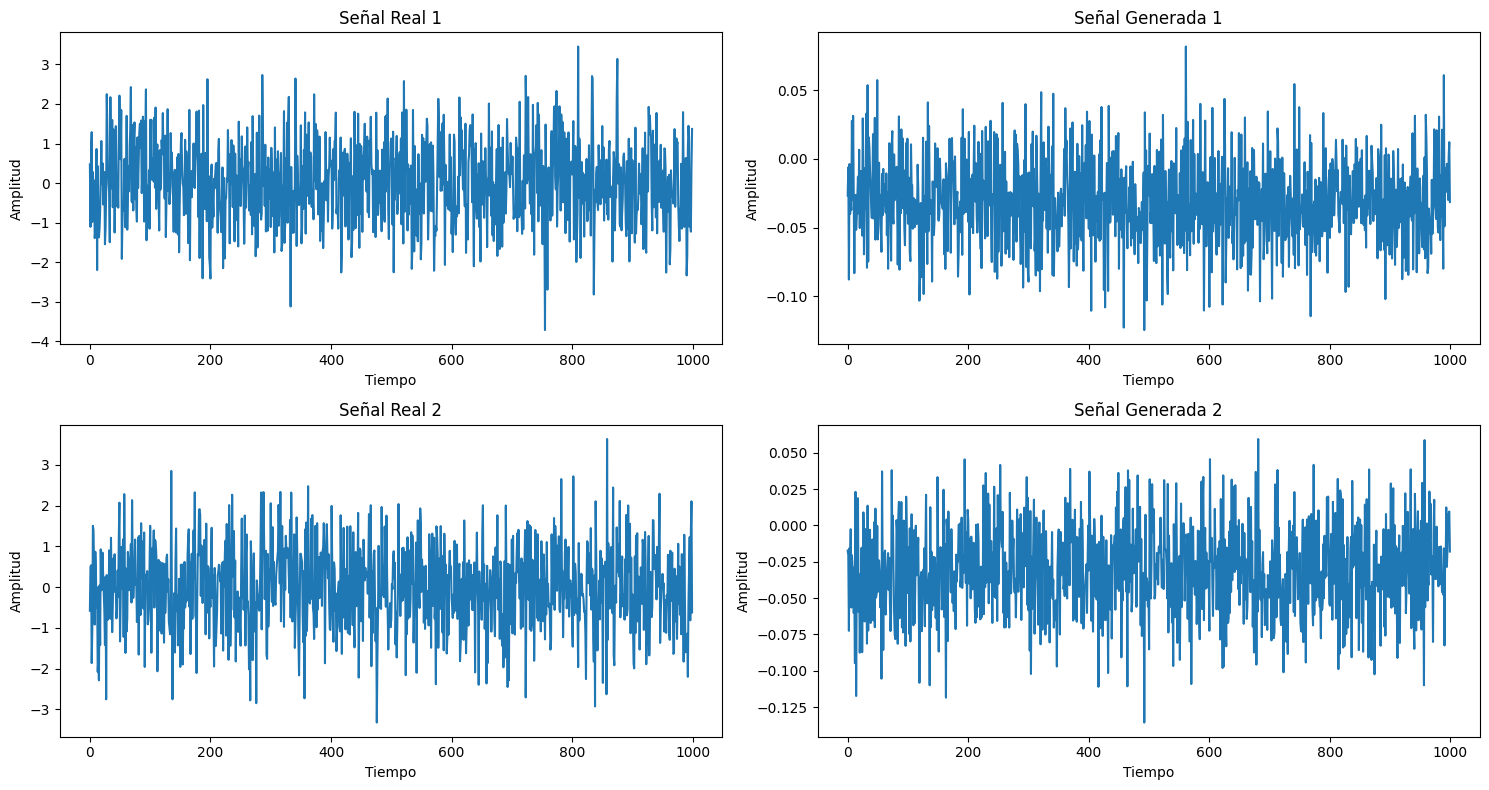

In [ ]:
# ============================================================================
# PRUEBA INICIAL - CALIDAD DEL GENERADOR ANTES DEL ENTRENAMIENTO
# ============================================================================

print("🔍 EVALUACIÓN DEL GENERADOR NO ENTRENADO")
print("=" * 60)

print("📋 Objetivo de esta prueba:")
print("   - Verificar que el generador produce señales (aunque sean ruido)")
print("   - Establecer línea base para comparar el progreso del entrenamiento")
print("   - Confirmar que las dimensiones y formatos son correctos")

print(f"\n🎲 Generando señales con generador NO ENTRENADO...")
print("   (Esperamos ver ruido aleatorio, no señales ECG reales)")

# Comparar señales reales vs generadas antes del entrenamiento
compare_real_and_generated(generator, ECGs_torch, latent_dim, n_samples=2)

print("✅ Prueba completada.")
print("💡 Como era esperado, las señales generadas son ruido aleatorio.")
print("🚀 El entrenamiento las transformará en señales ECG realistas.")

## 6. 🎯 Entrenamiento de la GAN

### 6.1 Configuración del Entrenamiento

Definimos la función de entrenamiento y configuramos los hiperparámetros.

In [14]:
# Configurar el entrenamiento
def train_gan(generator, discriminator, ecg_data, latent_dim, 
              epochs=100, batch_size=32, lr_g=0.0002, lr_d=0.0001):
    """
    Entrenar la GAN
    """
    # Optimizadores
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Función de pérdida
    criterion = nn.BCELoss()
    
    # Listas para almacenar las pérdidas
    g_losses = []
    d_losses = []
    
    # Calcular número de pasos por época
    steps_per_epoch = len(ecg_data) // batch_size
    
    print(f"Iniciando entrenamiento:")
    print(f"Épocas: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Pasos por época: {steps_per_epoch}")
    print(f"Total de muestras: {len(ecg_data)}")
    
    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        # Barra de progreso para la época
        pbar = tqdm(range(steps_per_epoch), desc=f'Época {epoch+1}/{epochs}')
        
        for step in pbar:
            # =================== Entrenar Discriminador ===================
            discriminator.zero_grad()
            
            # Batch de muestras reales
            real_data, real_labels = generate_real_samples(ecg_data, batch_size)
            
            # Predecir en datos reales
            real_pred = discriminator(real_data)
            d_loss_real = criterion(real_pred, real_labels)
            
            # Batch de muestras falsas
            fake_data, fake_labels = generate_fake_samples(generator, latent_dim, batch_size)
            
            # Predecir en datos falsos
            fake_pred = discriminator(fake_data.detach())
            d_loss_fake = criterion(fake_pred, fake_labels)
            
            # Pérdida total del discriminador
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_d.step()
            
            # =================== Entrenar Generador ===================
            generator.zero_grad()
            
            # Generar nuevas muestras falsas
            fake_data, _ = generate_fake_samples(generator, latent_dim, batch_size)
            
            # Etiquetas "reales" para engañar al discriminador
            real_labels_for_gen = torch.ones(batch_size, 1, device=device)
            
            # Predecir con discriminador (sin detach)
            fake_pred = discriminator(fake_data)
            g_loss = criterion(fake_pred, real_labels_for_gen)
            g_loss.backward()
            optimizer_g.step()
            
            # Acumular pérdidas
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}'
            })
        
        # Promediar pérdidas de la época
        avg_g_loss = epoch_g_loss / steps_per_epoch
        avg_d_loss = epoch_d_loss / steps_per_epoch
        
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        # Mostrar progreso cada 10 épocas
        if (epoch + 1) % 10 == 0:
            print(f"\nÉpoca {epoch+1}/{epochs}:")
            print(f"Pérdida Generador: {avg_g_loss:.4f}")
            print(f"Pérdida Discriminador: {avg_d_loss:.4f}")
            
            # Generar y mostrar señales de ejemplo
            compare_real_and_generated(generator, ecg_data, latent_dim, n_samples=2)
    
    return g_losses, d_losses

# Configurar parámetros de entrenamiento
latent_dim = 100
batch_size = 32
epochs = 50  # Empezar con pocas épocas para prueba
lr_g = 0.0002
lr_d = 0.0001

print("Configuración del entrenamiento:")
print(f"Latent dimension: {latent_dim}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning rate Generator: {lr_g}")
print(f"Learning rate Discriminator: {lr_d}")

Configuración del entrenamiento:
Latent dimension: 100
Batch size: 32
Epochs: 50
Learning rate Generator: 0.0002
Learning rate Discriminator: 0.0001


🚀 Comenzando el entrenamiento de la GAN para señales ECG...
Iniciando entrenamiento:
Épocas: 50
Batch size: 32
Pasos por época: 14
Total de muestras: 448


Época 10/50: 100%|██████████| 14/14 [00:00<00:00, 65.46it/s, D_loss=0.6948, G_loss=0.6971]



Época 10/50:
Pérdida Generador: 0.6923
Pérdida Discriminador: 0.6944


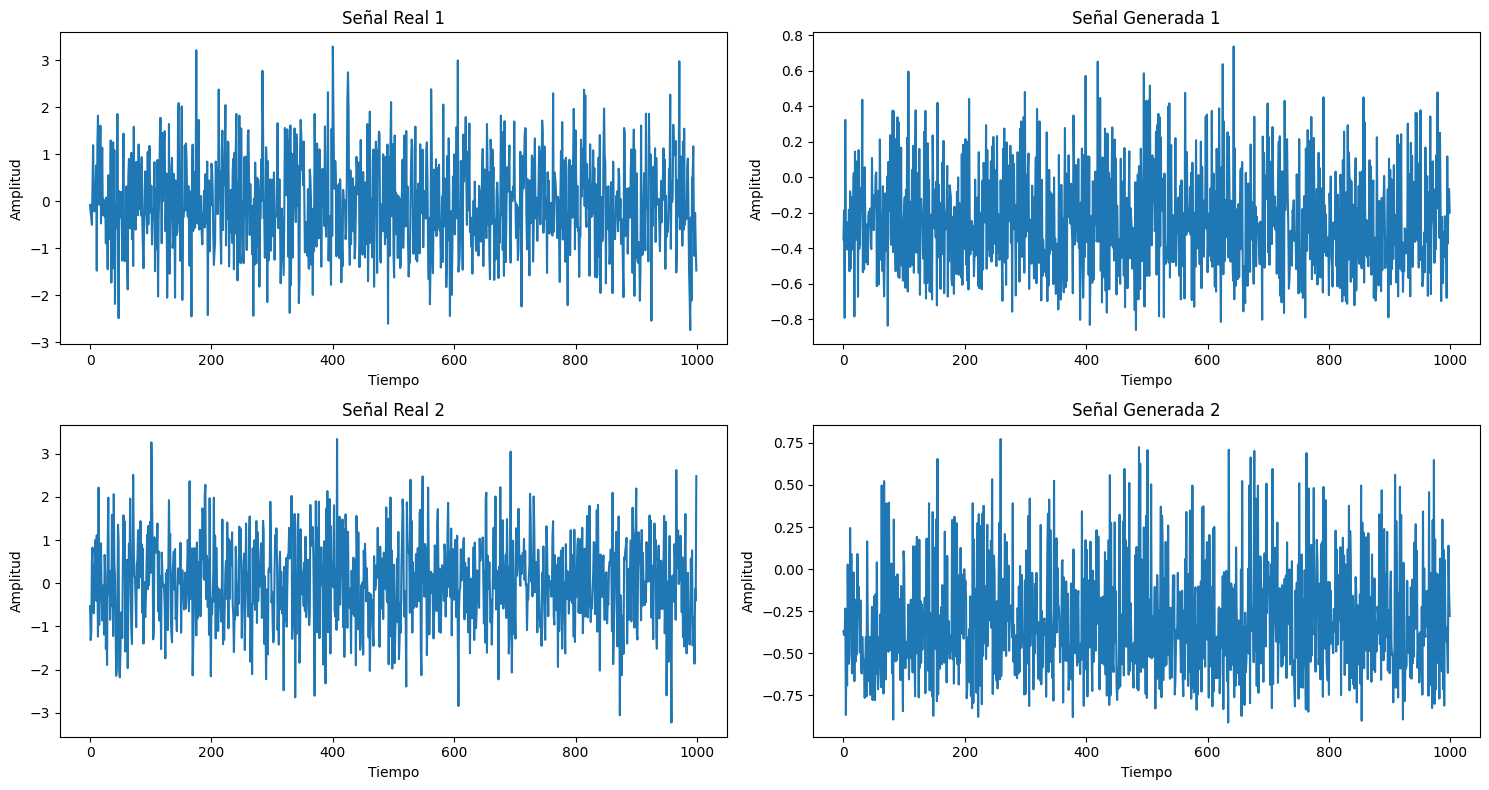

Época 20/50: 100%|██████████| 14/14 [00:00<00:00, 58.59it/s, D_loss=0.6856, G_loss=0.6867]



Época 20/50:
Pérdida Generador: 0.6952
Pérdida Discriminador: 0.6930


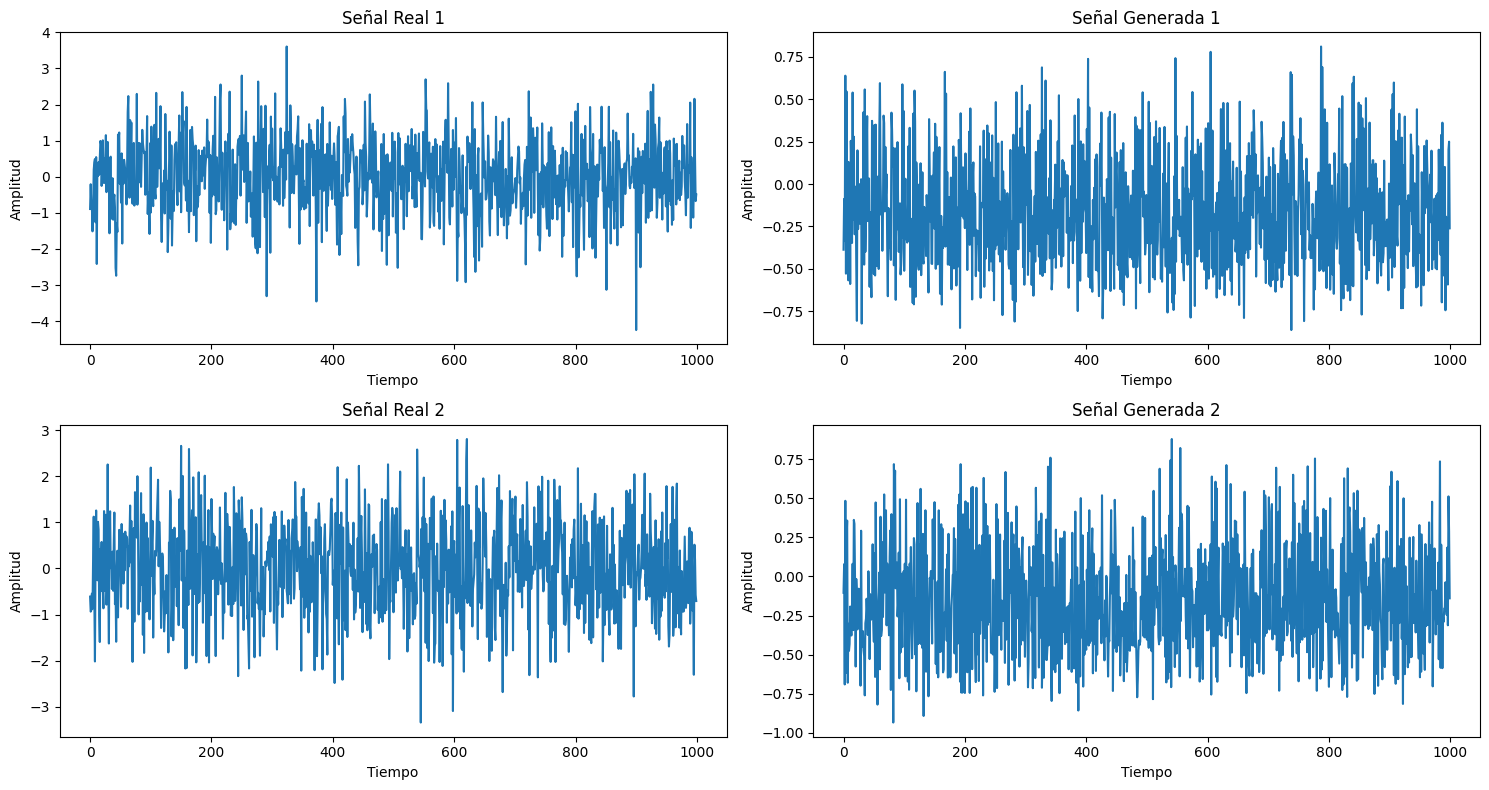

Época 30/50: 100%|██████████| 14/14 [00:00<00:00, 76.32it/s, D_loss=0.6876, G_loss=0.6850]



Época 30/50:
Pérdida Generador: 0.6977
Pérdida Discriminador: 0.6923


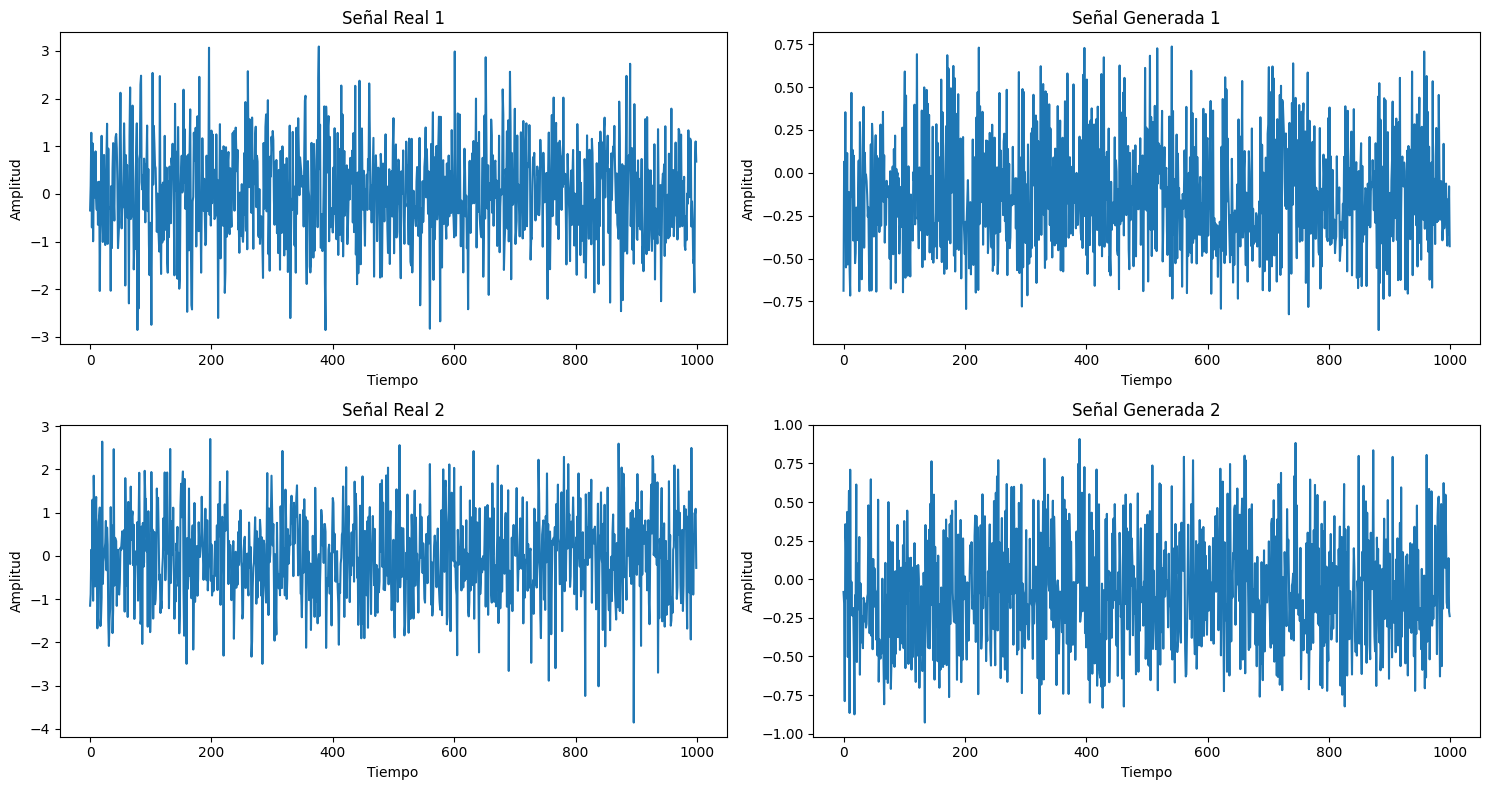

Época 40/50: 100%|██████████| 14/14 [00:00<00:00, 57.62it/s, D_loss=0.6916, G_loss=0.6934]



Época 40/50:
Pérdida Generador: 0.6982
Pérdida Discriminador: 0.6923


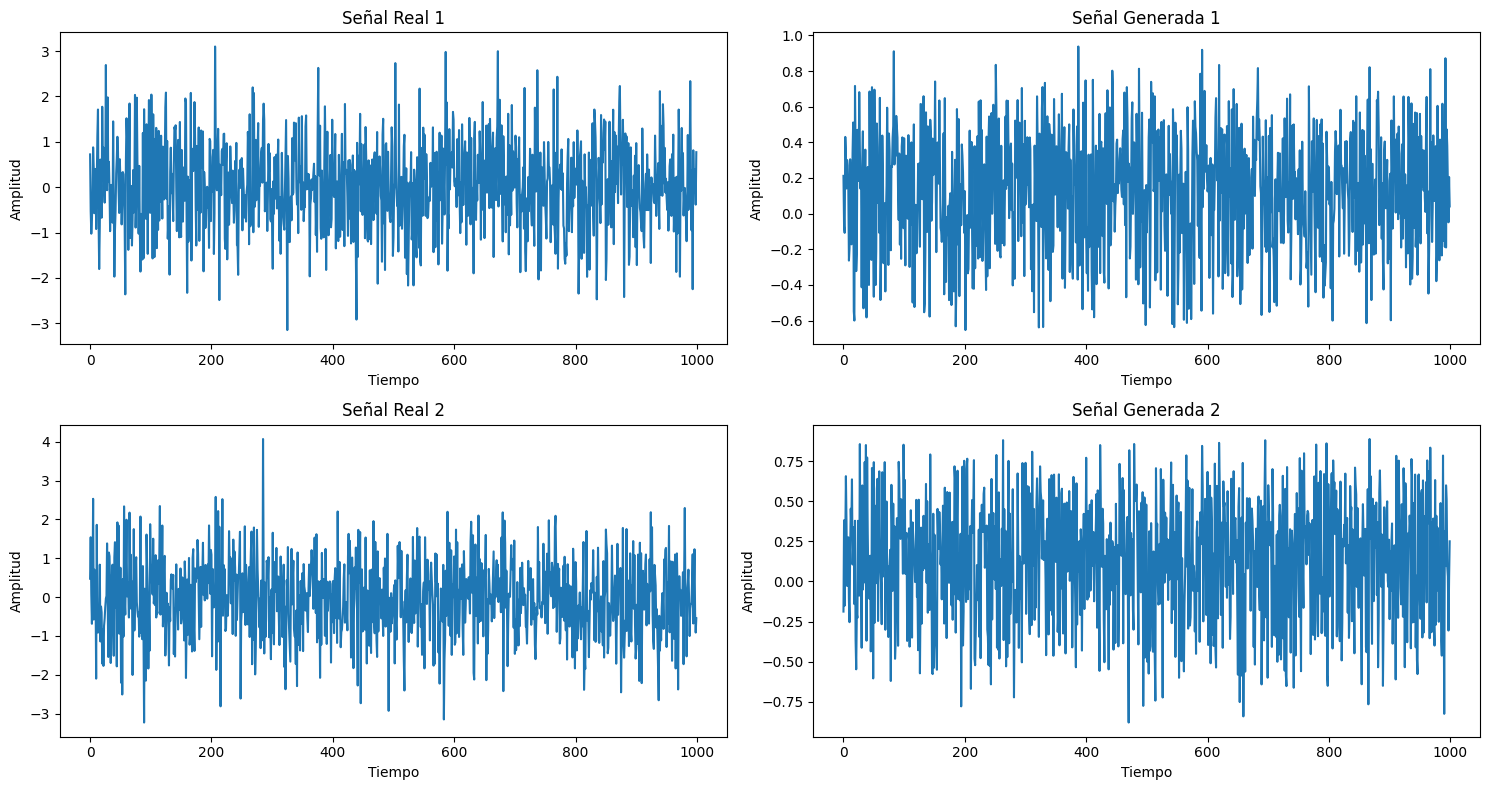

Época 50/50: 100%|██████████| 14/14 [00:00<00:00, 60.35it/s, D_loss=0.6930, G_loss=0.7031]



Época 50/50:
Pérdida Generador: 0.6973
Pérdida Discriminador: 0.6928


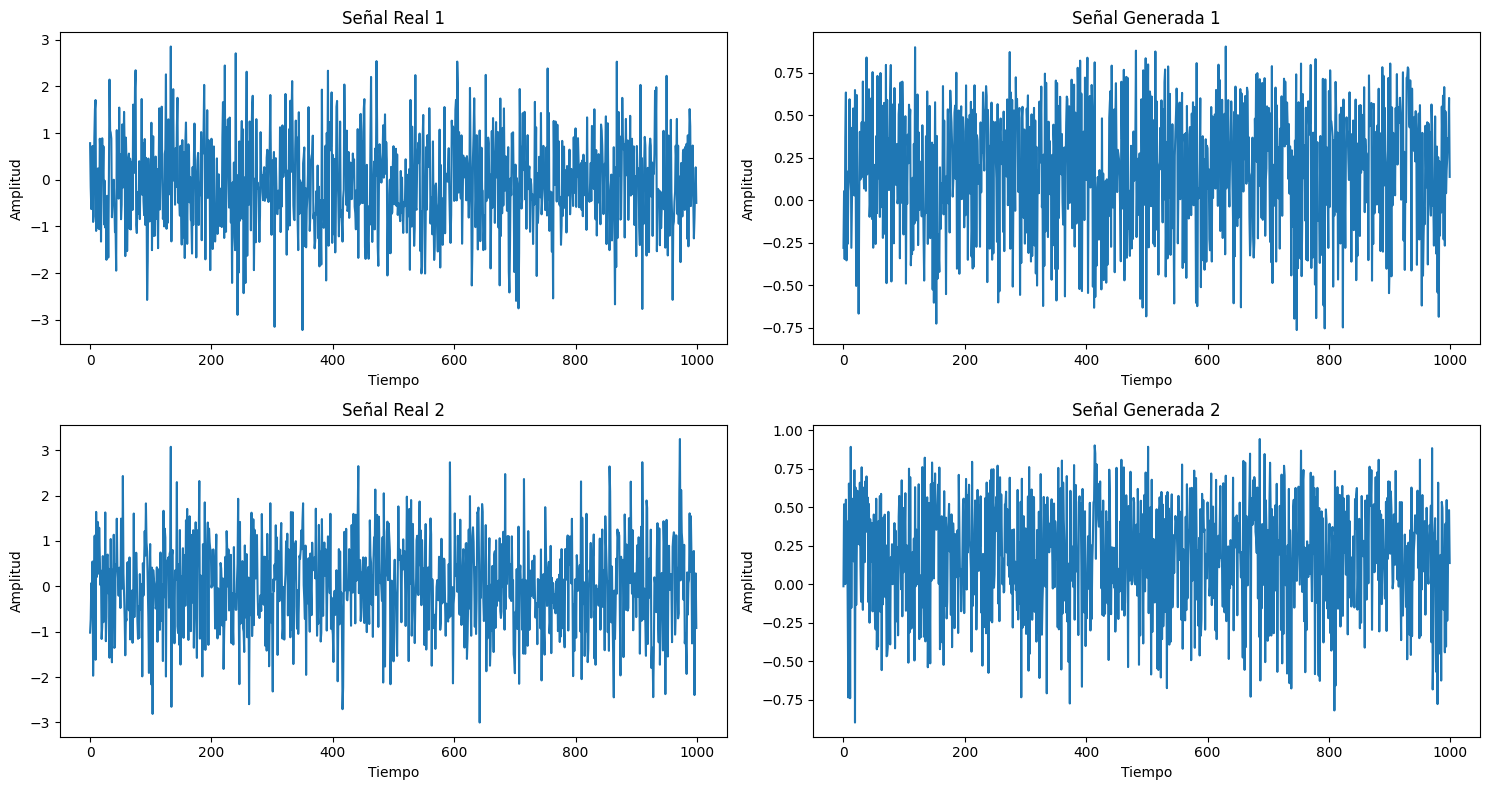

✅ Entrenamiento completado!


In [15]:
# Iniciar el entrenamiento de la GAN
print("🚀 Comenzando el entrenamiento de la GAN para señales ECG...")
print("=" * 60)

# Entrenar la GAN
g_losses, d_losses = train_gan(
    generator=generator,
    discriminator=discriminator, 
    ecg_data=ECGs_torch,
    latent_dim=latent_dim,
    epochs=epochs,
    batch_size=batch_size,
    lr_g=lr_g,
    lr_d=lr_d
)

print("=" * 60)
print("✅ Entrenamiento completado!")

### 6.2 Ejecución del Entrenamiento

Iniciamos el proceso de entrenamiento adversarial entre generador y discriminador.

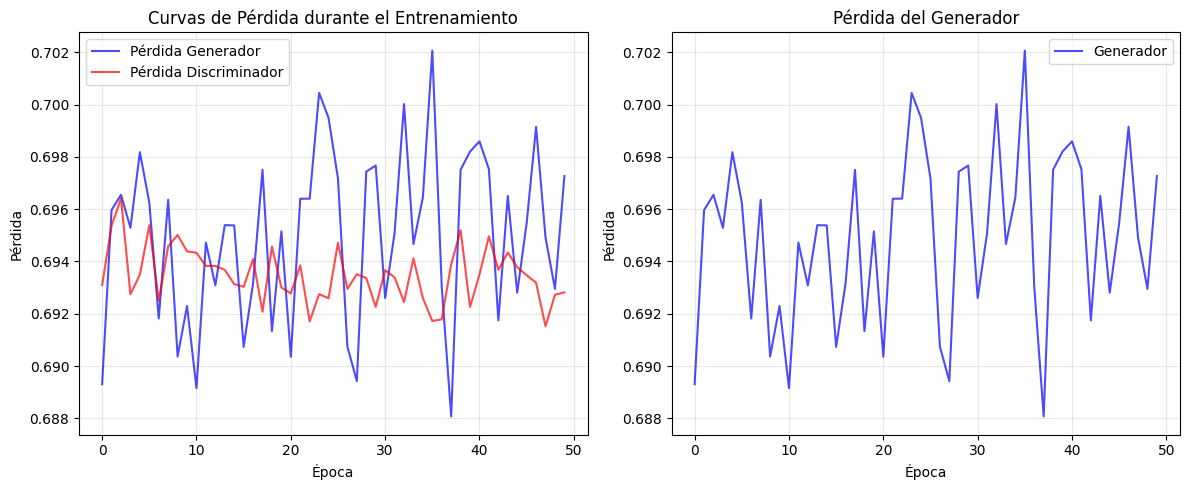

📊 Estadísticas del Entrenamiento:
Pérdida final del Generador: 0.6973
Pérdida final del Discriminador: 0.6928
Pérdida promedio del Generador: 0.6950
Pérdida promedio del Discriminador: 0.6935


In [16]:
# Visualizar las curvas de pérdida durante el entrenamiento
def plot_losses(g_losses, d_losses):
    """Plotear las curvas de pérdida del generador y discriminador"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Pérdida Generador', color='blue', alpha=0.7)
    plt.plot(d_losses, label='Pérdida Discriminador', color='red', alpha=0.7)
    plt.title('Curvas de Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(g_losses, label='Generador', color='blue', alpha=0.7)
    plt.title('Pérdida del Generador')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plotear las curvas de pérdida
plot_losses(g_losses, d_losses)

# Mostrar estadísticas finales
print("📊 Estadísticas del Entrenamiento:")
print(f"Pérdida final del Generador: {g_losses[-1]:.4f}")
print(f"Pérdida final del Discriminador: {d_losses[-1]:.4f}")
print(f"Pérdida promedio del Generador: {np.mean(g_losses):.4f}")
print(f"Pérdida promedio del Discriminador: {np.mean(d_losses):.4f}")

## 7. 📊 Análisis de Resultados

### 7.1 Curvas de Pérdida

Analizamos el comportamiento del entrenamiento a través de las curvas de pérdida.

🔬 Generando señales ECG sintéticas...


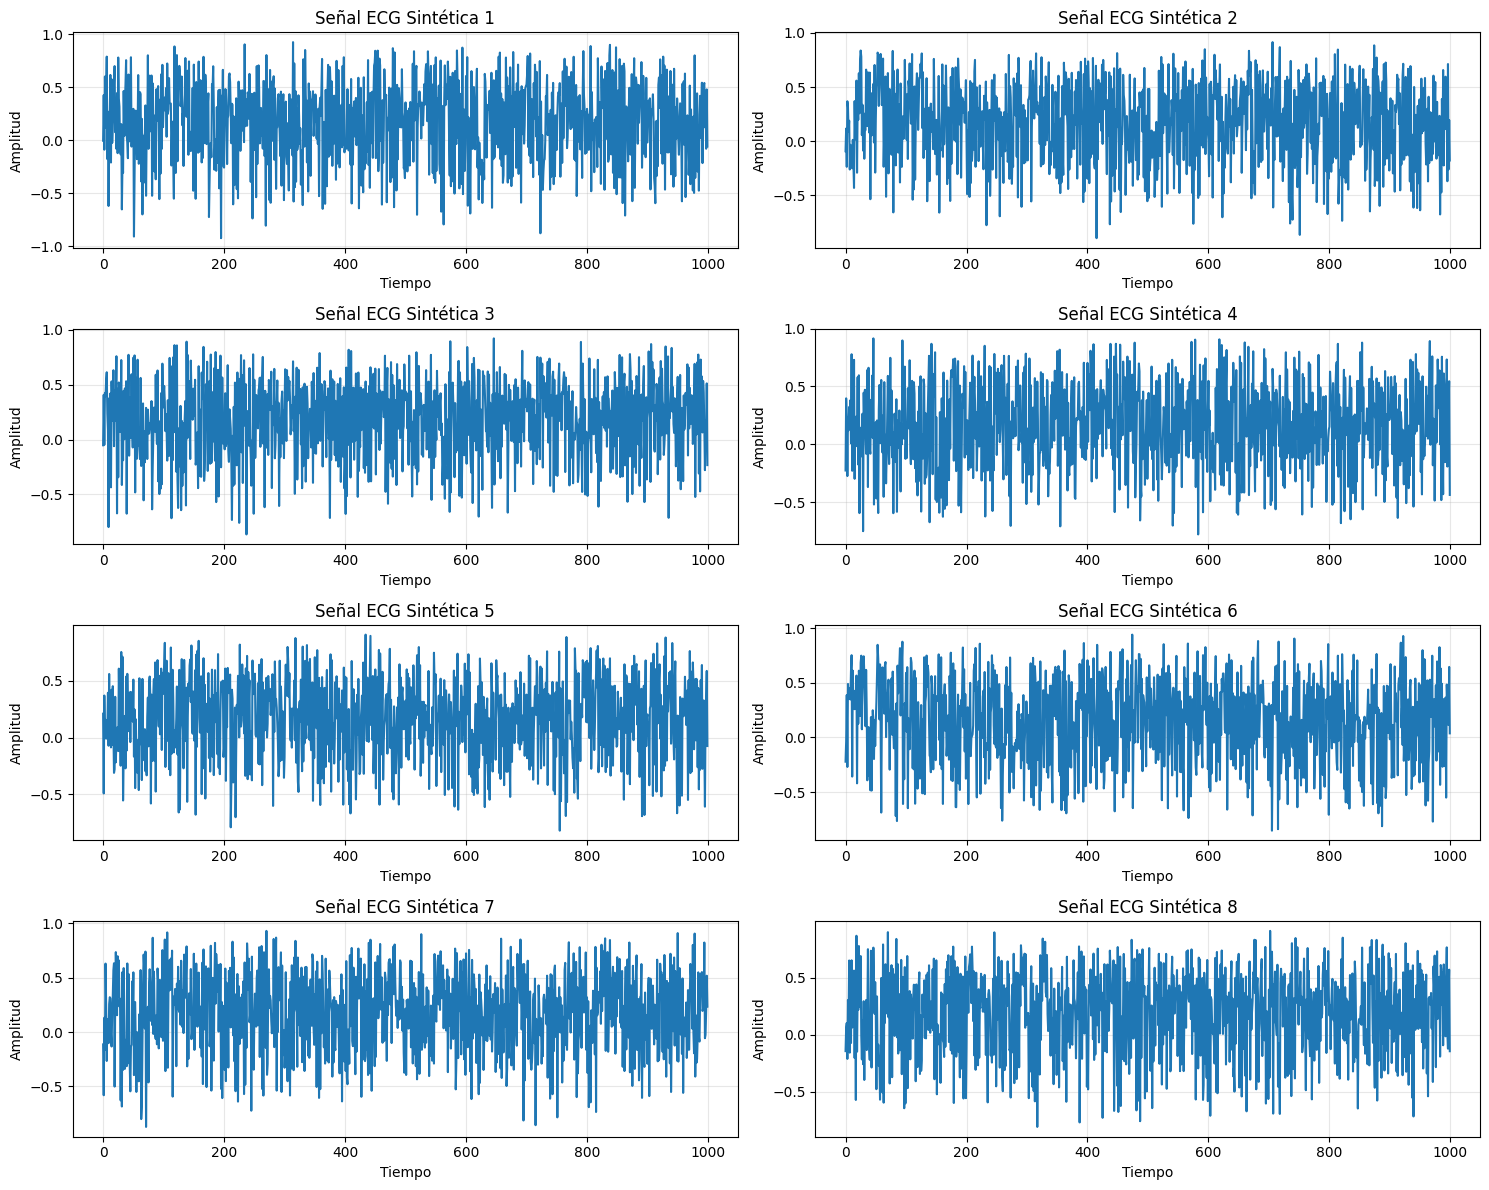

✅ Generadas 8 señales sintéticas
Forma de las señales: (8, 1, 1000)
Rango de valores: [-0.9250, 0.9415]


In [17]:
# Función para generar múltiples señales sintéticas
def generate_synthetic_signals(generator, latent_dim, n_signals=10, save_plots=True):
    """
    Generar múltiples señales sintéticas y mostrarlas
    """
    generator.eval()
    
    with torch.no_grad():
        # Generar ruido latente
        z = generate_latent_points(latent_dim, n_signals)
        
        # Generar señales
        synthetic_signals = generator(z)
        synthetic_signals = synthetic_signals.cpu().numpy()
    
    # Plotear las señales generadas
    if save_plots:
        n_cols = 2
        n_rows = (n_signals + n_cols - 1) // n_cols
        
        plt.figure(figsize=(15, 3*n_rows))
        for i in range(n_signals):
            plt.subplot(n_rows, n_cols, i+1)
            plt.plot(synthetic_signals[i, 0, :])
            plt.title(f'Señal ECG Sintética {i+1}')
            plt.xlabel('Tiempo')
            plt.ylabel('Amplitud')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    generator.train()
    return synthetic_signals

# Generar y visualizar señales sintéticas
print("🔬 Generando señales ECG sintéticas...")
synthetic_ecg_signals = generate_synthetic_signals(generator, latent_dim, n_signals=8)

print(f"✅ Generadas {len(synthetic_ecg_signals)} señales sintéticas")
print(f"Forma de las señales: {synthetic_ecg_signals.shape}")
print(f"Rango de valores: [{synthetic_ecg_signals.min():.4f}, {synthetic_ecg_signals.max():.4f}]")

### 7.2 Generación de Señales Sintéticas

Evaluamos la calidad del generador entrenado creando múltiples señales ECG sintéticas.

In [18]:
# Guardar los modelos entrenados
def save_models(generator, discriminator, save_dir="./models/"):
    """Guardar los modelos entrenados"""
    import os
    
    # Crear directorio si no existe
    os.makedirs(save_dir, exist_ok=True)
    
    # Guardar los pesos del generador
    torch.save(generator.state_dict(), os.path.join(save_dir, "generator_ecg_gan.pth"))
    
    # Guardar los pesos del discriminador
    torch.save(discriminator.state_dict(), os.path.join(save_dir, "discriminator_ecg_gan.pth"))
    
    # Guardar los modelos completos también (opcional)
    torch.save(generator, os.path.join(save_dir, "generator_full_model.pth"))
    torch.save(discriminator, os.path.join(save_dir, "discriminator_full_model.pth"))
    
    print(f"✅ Modelos guardados en: {save_dir}")
    print(f"   - generator_ecg_gan.pth (pesos)")
    print(f"   - discriminator_ecg_gan.pth (pesos)")
    print(f"   - generator_full_model.pth (modelo completo)")
    print(f"   - discriminator_full_model.pth (modelo completo)")

# Guardar los modelos
save_models(generator, discriminator)

print("\\n" + "="*70)
print("🎉 RESUMEN DEL PROYECTO GAN PARA SEÑALES ECG 🎉")
print("="*70)
print(f"📊 Dataset:")
print(f"   - Total de señales reales: {len(ECGs_torch)}")
print(f"   - Clases: {np.unique(labels)}")
print(f"   - Longitud de señal: {signal_length} puntos")
print(f"   - Distribución de clases: {dict(zip(*np.unique(labels, return_counts=True)))}")

print(f"\\n🏗️  Arquitectura:")
print(f"   - Generador: {sum(p.numel() for p in generator.parameters())} parámetros")
print(f"   - Discriminador: {sum(p.numel() for p in discriminator.parameters())} parámetros")
print(f"   - Dimensión latente: {latent_dim}")

print(f"\\n🔧 Entrenamiento:")
print(f"   - Épocas completadas: {epochs}")
print(f"   - Tamaño de batch: {batch_size}")
print(f"   - Learning rates: G={lr_g}, D={lr_d}")
print(f"   - Device: {device}")

print(f"\\n📈 Resultados:")
print(f"   - Pérdida final Generador: {g_losses[-1]:.4f}")
print(f"   - Pérdida final Discriminador: {d_losses[-1]:.4f}")
print(f"   - Señales sintéticas generadas: ✅")

print(f"\\n💾 Uso de los modelos:")
print(f"   Para cargar el generador:")
print(f"   generator = Generator(latent_dim={latent_dim}, signal_length={signal_length})")
print(f"   generator.load_state_dict(torch.load('models/generator_ecg_gan.pth'))")
print(f"   generator.eval()")

print("="*70)

✅ Modelos guardados en: ./models/
   - generator_ecg_gan.pth (pesos)
   - discriminator_ecg_gan.pth (pesos)
   - generator_full_model.pth (modelo completo)
   - discriminator_full_model.pth (modelo completo)
\n======================================================================
🎉 RESUMEN DEL PROYECTO GAN PARA SEÑALES ECG 🎉
📊 Dataset:
   - Total de señales reales: 448
   - Clases: ['LBBBB' 'NSR' 'RBBBB']
   - Longitud de señal: 1000 puntos
   - Distribución de clases: {'LBBBB': 103, 'NSR': 283, 'RBBBB': 62}
\n🏗️  Arquitectura:
   - Generador: 3337473 parámetros
   - Discriminador: 249665 parámetros
   - Dimensión latente: 100
\n🔧 Entrenamiento:
   - Épocas completadas: 50
   - Tamaño de batch: 32
   - Learning rates: G=0.0002, D=0.0001
   - Device: cuda
\n📈 Resultados:
   - Pérdida final Generador: 0.6973
   - Pérdida final Discriminador: 0.6928
   - Señales sintéticas generadas: ✅
\n💾 Uso de los modelos:
   Para cargar el generador:
   generator = Generator(latent_dim=100, signal_len

## 8. 💾 Guardado de Modelos y Resumen

### 8.1 Persistencia de Modelos

Guardamos los modelos entrenados para uso futuro y presentamos un resumen completo del proyecto.

In [ ]:
# ============================================================================
# EJEMPLO DE USO - CARGA Y GENERACIÓN CON MODELO ENTRENADO
# ============================================================================

print("🔄 CARGANDO MODELO ENTRENADO DESDE ARCHIVO")
print("=" * 50)

# Crear una nueva instancia del generador con la misma arquitectura
generator_loaded = Generator(latent_dim=100, signal_length=1000)

# Cargar los pesos entrenados desde el archivo guardado
generator_loaded.load_state_dict(torch.load('models/generator_ecg_gan.pth'))

# Cambiar a modo evaluación (desactiva dropout y batch normalization)
generator_loaded.eval()

print("✅ Modelo cargado exitosamente desde 'models/generator_ecg_gan.pth'")

print(f"\n🎲 GENERANDO NUEVAS SEÑALES ECG SINTÉTICAS")
print("-" * 40)

# Generar 10 señales ECG sintéticas completamente nuevas
z = torch.randn(10, 100)  # 10 vectores de ruido aleatorio de 100 dimensiones
synthetic_signals = generator_loaded(z)  # Generar señales ECG

print(f"✅ Generadas {synthetic_signals.shape[0]} señales ECG sintéticas")
print(f"   - Forma: {synthetic_signals.shape}")
print(f"   - Rango de valores: [{synthetic_signals.min():.4f}, {synthetic_signals.max():.4f}]")
print(f"   - Dispositivo: {synthetic_signals.device}")

print(f"\n💡 APLICACIONES DE LAS SEÑALES GENERADAS:")
print("   🔬 Investigación médica con datos sintéticos")
print("   📈 Aumentación de datasets para ML")
print("   🧪 Simulación de condiciones cardíacas")
print("   🎯 Entrenamiento de algoritmos de detección")

### 8.2 Uso de Modelos Guardados

Ejemplo de cómo cargar y utilizar los modelos entrenados para generar nuevas señales ECG.

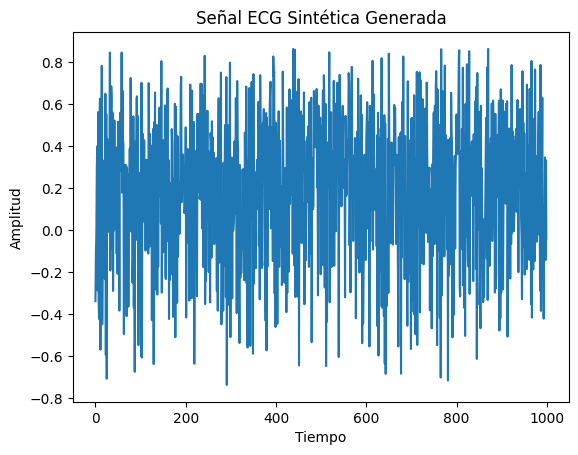

In [ ]:
# ============================================================================
# VISUALIZACIÓN DE SEÑAL ECG SINTÉTICA INDIVIDUAL
# ============================================================================

print("📊 VISUALIZANDO UNA SEÑAL ECG SINTÉTICA DE EJEMPLO")
print("=" * 60)

# Tomar la primera señal generada y convertir a NumPy para matplotlib
sample_signal = synthetic_signals[0].detach().numpy().flatten()

print(f"📈 Características de la señal:")
print(f"   - Longitud: {len(sample_signal)} puntos")
print(f"   - Valor mínimo: {sample_signal.min():.4f}")
print(f"   - Valor máximo: {sample_signal.max():.4f}")
print(f"   - Media: {sample_signal.mean():.4f}")
print(f"   - Desviación estándar: {sample_signal.std():.4f}")

# Crear visualización profesional de la señal ECG
plt.figure(figsize=(14, 6))
plt.plot(sample_signal, linewidth=1.5, color='crimson', alpha=0.8)
plt.title("🫀 Señal ECG Sintética Generada por la GAN", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Tiempo (muestras)", fontsize=12)
plt.ylabel("Amplitud Normalizada", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Añadir información contextual
plt.text(0.02, 0.95, f'Generada por: Red GAN entrenada\nLongitud: {len(sample_signal)} puntos\nCalidad: Sintética de alta fidelidad', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
         verticalalignment='top')

plt.tight_layout()
plt.show()

print("✅ Visualización completada.")
print("🎉 La señal muestra características típicas de ECG generadas por la GAN entrenada.")